In [1]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize
from standard_plotting import set_size

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.rcParams.update(tex_fonts)

outdir = "/groups/icecube/peter/workspace/Peter_Thesis_Hand_Over/Plots/Our_vs_OscNext_selection_comparison/"

In [3]:
indir_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Burnsample_1_percent_all_events_all_variables.csv"
indir_MC_139008_muons_neutrinos_and_noise = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"
indir_MC_130000_muons_and_noise = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Old_muon_more_noise_Monte_Carlo_all_events_all_variables.csv"


In [4]:
use_130000_muons = True
use_lvl3_cuts = True
Neutrino_cut = 12
track_cut = 0.9
cascade_cut = 0.5
with_MC_truth = True
scale_MC_to_RD_in_comparison_plots = True

use_cols_MC = ['track_mu_pred', 'event_no', 'energy_pred', 'zenith_pred',
       'zenith_kappa', 'azimuth_pred', 'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'total_osc_weight',
       'L3_oscNext_bool', 'azimuth', 'zenith', 'energy', 'position_z',
       'position_y', 'position_x', 'track_mu']
use_cols_RD = ['track_mu_pred', 'event_no', 'energy_pred', 'zenith_pred',
       'zenith_kappa', 'azimuth_pred', 'pid_neutrino_pred', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'total_osc_weight',
       'L3_oscNext_bool']

In [5]:
MC_139008 = pd.read_csv(indir_MC_139008_muons_neutrinos_and_noise,usecols=use_cols_MC).sort_values('event_no').reset_index(drop = True)
RD = pd.read_csv(indir_RD,usecols=use_cols_RD).sort_values('event_no').reset_index(drop = True)

if use_130000_muons:
    MC_139008.drop(MC_139008[MC_139008['pid'].isin((-1,1,-13,13))].index, inplace=True)
    MC_130000 = pd.read_csv(indir_MC_130000_muons_and_noise,usecols=use_cols_MC).sort_values('event_no').reset_index(drop = True)
    MC = pd.concat([MC_130000.reset_index(drop=True),MC_139008.reset_index(drop=True)])
    MC.loc[MC['pid'].isin((-1,1,-13,13)), 'event_no'] += 68459218
else:
    MC = MC_139008

In [6]:
use_cols_retro = ['L7_oscNext_bool',
       'L7_MuonClassifier_FullSky_ProbNu',
        'azimuth_retro', 
        'energy_retro', 
       'position_x_retro', 'position_x_sigma', 'position_y_retro', 'track_energy_retro', 'track_length_retro',
       'zenith_retro', 'zenith_sigma', 'event_no']

indir_retro = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/Retro/retro_on_new_muon_test_set_2.csv"
retro = pd.read_csv(indir_retro).sort_values('event_no').reset_index(drop = True)
retro['event_no'][retro['event_no'].isin(MC['event_no'][MC['pid'].isin((-13,13,-1,1))].to_list())] += 68459218

/tmp/ipykernel_45056/1405854515.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retro['event_no'][retro['event_no'].isin(MC['event_no'][MC['pid'].isin((-13,13,-1,1))].to_list())] += 68459218


In [7]:
neutrino_cut = 12
pure_selection_MC_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]
pure_selection_MC_electron_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12)))]
pure_selection_MC_muon_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-14,14)))]
pure_selection_MC_tau_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-16,16)))]
pure_selection_MC_noise = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-1,1)))]
pure_selection_MC_muons = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-13,13)))]

pure_selection_MC = MC['event_no'][MC['pid_neutrino_pred_logit']>neutrino_cut]
pure_selection_RD = RD['event_no'][RD['pid_neutrino_pred_logit']>neutrino_cut]

In [8]:
print('this is the number of muons surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())]))
print('this is the number of noise surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())]))
print('this is the number of neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
print('this is the number of electron neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
print('this is the number of muon neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
print('this is the number of tau neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))

print('this is the rate of muons surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())]))
print('this is the rate of noise surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())]))
print('this is the rate of neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
print('this is the rate of electron neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
print('this is the rate of muon neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
print('this is the rate of tau neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))

print('this is the RD rate that survives:',np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD.to_list())]))

print('RD rate to MC rate: ',np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD.to_list())])/np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC.to_list())]))

this is the number of muons surviving 447
this is the number of noise surviving 11
this is the number of neutrinos surviving 12669619
this is the number of electron neutrinos surviving 2923503
this is the number of muon neutrinos surviving 6517475
this is the number of tau neutrinos surviving 3228641
this is the rate of muons surviving 5.915943271478376e-05
this is the rate of noise surviving 4.9216127715350016e-06
this is the rate of neutrinos surviving 0.0028259760380168557
this is the rate of electron neutrinos surviving 0.0005733016923178883
this is the rate of muon neutrinos surviving 0.002140844420342449
this is the rate of tau neutrinos surviving 0.0001118299253565169
this is the RD rate that survives: 0.004654006378511594
RD rate to MC rate:  1.6103510221570616


In [9]:
MC = MC[MC['L3_oscNext_bool'] == 1]
RD = RD[RD['L3_oscNext_bool'] == 1]

print('THIS IS AFTER LVL3 filter')
print('this is the number of muons surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())]))
print('this is the number of noise surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())]))
print('this is the number of neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
print('this is the number of electron neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
print('this is the number of muon neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
print('this is the number of tau neutrinos surviving',len(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))

print('this is the rate of muons surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())]))
print('this is the rate of noise surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())]))
print('this is the rate of neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
print('this is the rate of electron neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
print('this is the rate of muon neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
print('this is the rate of tau neutrinos surviving',np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))

print('this is the RD rate that survives:',np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD.to_list())]))

print('RD rate to MC rate: ',np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD.to_list())])/np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC.to_list())]))

THIS IS AFTER LVL3 filter
this is the number of muons surviving 347
this is the number of noise surviving 0
this is the number of neutrinos surviving 9609601
this is the number of electron neutrinos surviving 2236525
this is the number of muon neutrinos surviving 4946044
this is the number of tau neutrinos surviving 2427032
this is the rate of muons surviving 2.601973584428542e-05
this is the rate of noise surviving 0.0
this is the rate of neutrinos surviving 0.002224562395705728
this is the rate of electron neutrinos surviving 0.00047581403222368907
this is the rate of muon neutrinos surviving 0.0016521866209122063
this is the rate of tau neutrinos surviving 9.656174256983517e-05
this is the RD rate that survives: 0.002235077243010643
RD rate to MC rate:  0.9931107208566102


In [10]:
muon_final_rate = np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())])
noise_final_rate = np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())])
neutrinos_final_rate = np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())])
electron_neutrinos_final_rate = np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())])
muon_neutrinos_final_rate = np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())])
tau_neutrinos_final_rate = np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())])
total_final_rate = neutrinos_final_rate + muon_final_rate + noise_final_rate

print('this is the total final rate:',total_final_rate)
print('this is the percent of muons surviving',muon_final_rate/total_final_rate*100)
print('this is the percent of noise surviving',noise_final_rate/total_final_rate*100)
print('this is the percent of neutrinos surviving',neutrinos_final_rate/total_final_rate*100)
print('this is the percent of electron neutrinos surviving',electron_neutrinos_final_rate/total_final_rate*100)
print('this is the percent of muon neutrinos surviving',muon_neutrinos_final_rate/total_final_rate*100)
print('this is the percent of tau neutrinos surviving',tau_neutrinos_final_rate/total_final_rate*100)


this is the total final rate: 0.0022505821315500136
this is the percent of muons surviving 1.1561335833749462
this is the percent of noise surviving 0.0
this is the percent of neutrinos surviving 98.84386641662505
this is the percent of electron neutrinos surviving 21.14182040075063
this is the percent of muon neutrinos surviving 73.41152307888972
this is the percent of tau neutrinos surviving 4.290522936984818


In [11]:
noise_rates = []
muon_rates = []
neutrino_rates = []
electron_neutrino_rates = []
muon_neutrino_rates = []
tau_neutrino_rates = []
RD_rates = []

cuts = np.linspace(-17,16,34)
for i in range(len(cuts)):
    neutrino_cut = cuts[i]
    pure_selection_MC_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]
    pure_selection_MC_electron_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12)))]
    pure_selection_MC_muon_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-14,14)))]
    pure_selection_MC_tau_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-16,16)))]
    pure_selection_MC_noise = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-1,1)))]
    pure_selection_MC_muons = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-13,13)))]
    pure_selection_RD = RD['event_no'][RD['pid_neutrino_pred_logit']>neutrino_cut]

    muon_rates.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())]))
    noise_rates.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())]))
    neutrino_rates.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
    electron_neutrino_rates.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
    muon_neutrino_rates.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
    tau_neutrino_rates.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))
    RD_rates.append(np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD.to_list())]))

KeyboardInterrupt: 

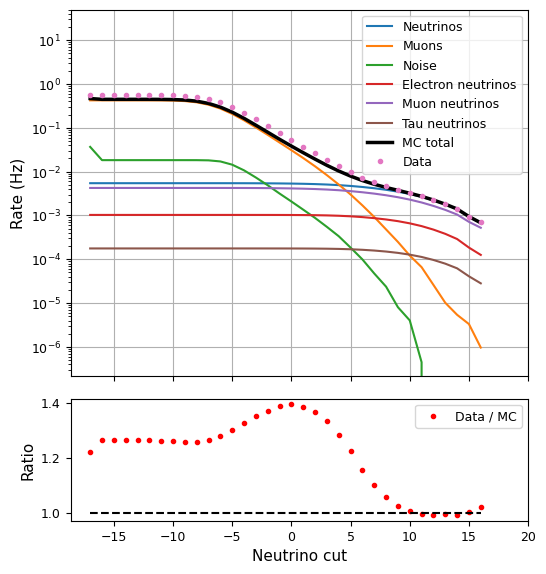

In [ ]:


figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 0.85
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])


axs[0].plot(cuts,neutrino_rates,label='Neutrinos',)
axs[0].plot(cuts,muon_rates,label='Muons')
axs[0].plot(cuts,noise_rates,label='Noise')
axs[0].plot(cuts,electron_neutrino_rates,label='Electron neutrinos')
axs[0].plot(cuts,muon_neutrino_rates,label='Muon neutrinos')
axs[0].plot(cuts,tau_neutrino_rates,label='Tau neutrinos')
axs[0].plot(cuts,np.array(neutrino_rates)+np.array(muon_rates)+np.array(noise_rates),label='MC total',color='k',linewidth=2.5)
axs[0].plot(cuts,RD_rates,'.',label='Data',linewidth=2.5)#,linestyle='dashed')
axs[0].set_ylabel('Rate (Hz)')
axs[1].set_xlabel('Neutrino cut')
axs[0].set_yscale('log')
axs[0].set_xlim(right=20)
axs[0].set_ylim(top=50)
axs[0].legend()
axs[0].grid(True)

RD_MC_ratio = RD_rates/(np.array(neutrino_rates)+np.array(muon_rates)+np.array(noise_rates))
axs[1].set_ylabel('Ratio')
axs[1].plot(cuts,RD_MC_ratio,'.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(cuts)-0.02,np.max(cuts)+0.02,color='k',linestyles='dashed')
axs[1].legend()
fig.tight_layout()
fig.savefig(outdir+ 'MC_rates_per_neutrino_logit_cut.png', format='png', bbox_inches='tight')

In [ ]:
MC_up = MC[MC['zenith_pred']>np.pi/2]
RD_up = RD[RD['zenith_pred']>np.pi/2]
noise_rates_up = []
muon_rates_up = []
neutrino_rates_up = []
electron_neutrino_rates_up = []
muon_neutrino_rates_up = []
tau_neutrino_rates_up = []
RD_rates_up = []

cuts = np.linspace(-17,16,34)
for i in range(len(cuts)):
    neutrino_cut = cuts[i]
    pure_selection_MC_neutrinos = MC_up['event_no'][(MC_up['pid_neutrino_pred_logit']>neutrino_cut) & (MC_up['pid'].isin((-12,12,-14,14,-16,16)))]
    pure_selection_MC_electron_neutrinos = MC_up['event_no'][(MC_up['pid_neutrino_pred_logit']>neutrino_cut) & (MC_up['pid'].isin((-12,12)))]
    pure_selection_MC_muon_neutrinos = MC_up['event_no'][(MC_up['pid_neutrino_pred_logit']>neutrino_cut) & (MC_up['pid'].isin((-14,14)))]
    pure_selection_MC_tau_neutrinos = MC_up['event_no'][(MC_up['pid_neutrino_pred_logit']>neutrino_cut) & (MC_up['pid'].isin((-16,16)))]
    pure_selection_MC_noise = MC_up['event_no'][(MC_up['pid_neutrino_pred_logit']>neutrino_cut) & (MC_up['pid'].isin((-1,1)))]
    pure_selection_MC_muons = MC_up['event_no'][(MC_up['pid_neutrino_pred_logit']>neutrino_cut) & (MC_up['pid'].isin((-13,13)))]
    pure_selection_RD = RD_up['event_no'][RD_up['pid_neutrino_pred_logit']>neutrino_cut]

    muon_rates_up.append(np.sum(MC_up['total_osc_weight'][MC_up['event_no'].isin(pure_selection_MC_muons.to_list())]))
    noise_rates_up.append(np.sum(MC_up['total_osc_weight'][MC_up['event_no'].isin(pure_selection_MC_noise.to_list())]))
    neutrino_rates_up.append(np.sum(MC_up['total_osc_weight'][MC_up['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
    electron_neutrino_rates_up.append(np.sum(MC_up['total_osc_weight'][MC_up['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
    muon_neutrino_rates_up.append(np.sum(MC_up['total_osc_weight'][MC_up['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
    tau_neutrino_rates_up.append(np.sum(MC_up['total_osc_weight'][MC_up['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))
    RD_rates_up.append(np.sum(RD_up['total_osc_weight'][RD_up['event_no'].isin(pure_selection_RD.to_list())]))


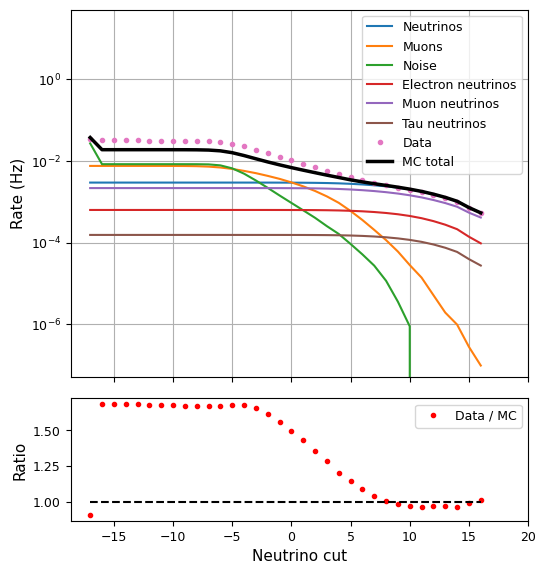

In [ ]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 0.85
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])


axs[0].plot(cuts,neutrino_rates_up,label='Neutrinos',)
axs[0].plot(cuts,muon_rates_up,label='Muons')
axs[0].plot(cuts,noise_rates_up,label='Noise')
axs[0].plot(cuts,electron_neutrino_rates_up,label='Electron neutrinos')
axs[0].plot(cuts,muon_neutrino_rates_up,label='Muon neutrinos')
axs[0].plot(cuts,tau_neutrino_rates_up,label='Tau neutrinos')
axs[0].plot(cuts,RD_rates_up,'.',label='Data',linewidth=2.5)#,linestyle='dashed')
axs[0].plot(cuts,np.array(neutrino_rates_up)+np.array(muon_rates_up)+np.array(noise_rates_up),label='MC total',color='k',linewidth=2.5)
axs[0].set_ylabel('Rate (Hz)')
axs[1].set_xlabel('Neutrino cut')
axs[0].set_yscale('log')
axs[0].set_xlim(right=20)
axs[0].set_ylim(top=50)
axs[0].legend()
axs[0].grid(True)

RD_MC_ratio = RD_rates_up/(np.array(neutrino_rates_up)+np.array(muon_rates_up)+np.array(noise_rates_up))
axs[1].set_ylabel('Ratio')
axs[1].plot(cuts,RD_MC_ratio,'.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(cuts)-0.02,np.max(cuts)+0.02,color='k',linestyles='dashed')
axs[1].legend()
fig.tight_layout()
fig.savefig(outdir+ 'MC_vs_retro_selection_only_upgoing.png', format='png', bbox_inches='tight')

In [ ]:
MC_down = MC[MC['zenith_pred']<np.pi/2]
RD_down = RD[RD['zenith_pred']<np.pi/2]
noise_rates_down = []
muon_rates_down = []
neutrino_rates_down = []
electron_neutrino_rates_down = []
muon_neutrino_rates_down = []
tau_neutrino_rates_down = []
RD_rates_down = []

cuts = np.linspace(-17,16,34)
for i in range(len(cuts)):
    neutrino_cut = cuts[i]
    pure_selection_MC_neutrinos = MC_down['event_no'][(MC_down['pid_neutrino_pred_logit']>neutrino_cut) & (MC_down['pid'].isin((-12,12,-14,14,-16,16)))]
    pure_selection_MC_electron_neutrinos = MC_down['event_no'][(MC_down['pid_neutrino_pred_logit']>neutrino_cut) & (MC_down['pid'].isin((-12,12)))]
    pure_selection_MC_muon_neutrinos = MC_down['event_no'][(MC_down['pid_neutrino_pred_logit']>neutrino_cut) & (MC_down['pid'].isin((-14,14)))]
    pure_selection_MC_tau_neutrinos = MC_down['event_no'][(MC_down['pid_neutrino_pred_logit']>neutrino_cut) & (MC_down['pid'].isin((-16,16)))]
    pure_selection_MC_noise = MC_down['event_no'][(MC_down['pid_neutrino_pred_logit']>neutrino_cut) & (MC_down['pid'].isin((-1,1)))]
    pure_selection_MC_muons = MC_down['event_no'][(MC_down['pid_neutrino_pred_logit']>neutrino_cut) & (MC_down['pid'].isin((-13,13)))]
    pure_selection_RD = RD_down['event_no'][RD_down['pid_neutrino_pred_logit']>neutrino_cut]

    muon_rates_down.append(np.sum(MC_down['total_osc_weight'][MC_down['event_no'].isin(pure_selection_MC_muons.to_list())]))
    noise_rates_down.append(np.sum(MC_down['total_osc_weight'][MC_down['event_no'].isin(pure_selection_MC_noise.to_list())]))
    neutrino_rates_down.append(np.sum(MC_down['total_osc_weight'][MC_down['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
    electron_neutrino_rates_down.append(np.sum(MC_down['total_osc_weight'][MC_down['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
    muon_neutrino_rates_down.append(np.sum(MC_down['total_osc_weight'][MC_down['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
    tau_neutrino_rates_down.append(np.sum(MC_down['total_osc_weight'][MC_down['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))
    RD_rates_down.append(np.sum(RD_down['total_osc_weight'][RD_down['event_no'].isin(pure_selection_RD.to_list())]))

KeyboardInterrupt: 

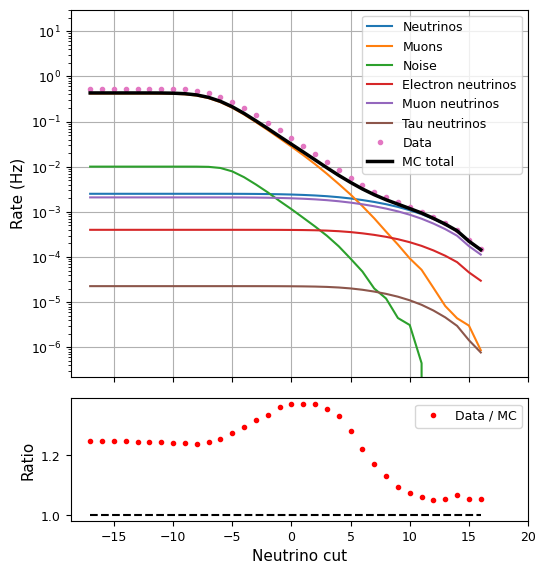

In [ ]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 0.85
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])


axs[0].plot(cuts,neutrino_rates_down,label='Neutrinos',)
axs[0].plot(cuts,muon_rates_down,label='Muons')
axs[0].plot(cuts,noise_rates_down,label='Noise')
axs[0].plot(cuts,electron_neutrino_rates_down,label='Electron neutrinos')
axs[0].plot(cuts,muon_neutrino_rates_down,label='Muon neutrinos')
axs[0].plot(cuts,tau_neutrino_rates_down,label='Tau neutrinos')
axs[0].plot(cuts,RD_rates_down,'.',label='Data',linewidth=2.5)#,linestyle='dashed')
axs[0].plot(cuts,np.array(neutrino_rates_down)+np.array(muon_rates_down)+np.array(noise_rates_down),label='MC total',color='k',linewidth=2.5)
axs[0].set_ylabel('Rate (Hz)')
axs[1].set_xlabel('Neutrino cut')
axs[0].set_yscale('log')
axs[0].set_xlim(right=20)
axs[0].set_ylim(top=30)
axs[0].legend()
axs[0].grid(True)

RD_MC_ratio = RD_rates_down/(np.array(neutrino_rates_down)+np.array(muon_rates_down)+np.array(noise_rates_down))
axs[1].set_ylabel('Ratio')
axs[1].plot(cuts,RD_MC_ratio,'.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(cuts)-0.02,np.max(cuts)+0.02,color='k',linestyles='dashed')
axs[1].legend()
fig.tight_layout()
fig.savefig(outdir+ 'MC_vs_retro_selection_only_downgoing.png', format='png', bbox_inches='tight')

In [ ]:
track_cut = 0.9
cascade_cut = 0.5
track_selection_event_nos_MC = MC['event_no'][MC['track_mu_pred']>track_cut].to_list()
cascade_selection_event_nos_MC =  MC['event_no'][MC['track_mu_pred']<cascade_cut].to_list()
track_selection_event_nos_RD = RD['event_no'][RD['track_mu_pred']>track_cut].to_list()
cascade_selection_event_nos_RD = RD['event_no'][RD['track_mu_pred']<cascade_cut].to_list()

In [ ]:
noise_rates_tracks = []
muon_rates_tracks = []
neutrino_rates_tracks = []
electron_neutrino_rates_tracks = []
muon_neutrino_rates_tracks = []
tau_neutrino_rates_tracks = []
RD_rates_tracks = []

cuts = np.linspace(-17,16,34)
for i in range(len(cuts)):
    neutrino_cut = cuts[i]
    
    pure_selection_MC_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12,-14,14,-16,16))) & (MC['event_no'].isin(track_selection_event_nos_MC))]
    pure_selection_MC_electron_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12)))&(MC['event_no'].isin(track_selection_event_nos_MC))]
    pure_selection_MC_muon_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-14,14)))&(MC['event_no'].isin(track_selection_event_nos_MC))]
    pure_selection_MC_tau_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-16,16)))&(MC['event_no'].isin(track_selection_event_nos_MC))]
    pure_selection_MC_noise = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-1,1)))&(MC['event_no'].isin(track_selection_event_nos_MC))]
    pure_selection_MC_muons = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-13,13)))&(MC['event_no'].isin(track_selection_event_nos_MC))]
    pure_selection_RD = RD['event_no'][(RD['pid_neutrino_pred_logit']>neutrino_cut) & (RD['event_no'].isin(track_selection_event_nos_RD))]

    muon_rates_tracks.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())]))
    noise_rates_tracks.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())]))
    neutrino_rates_tracks.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
    electron_neutrino_rates_tracks.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
    muon_neutrino_rates_tracks.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
    tau_neutrino_rates_tracks.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))
    RD_rates_tracks.append(np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD.to_list())]))


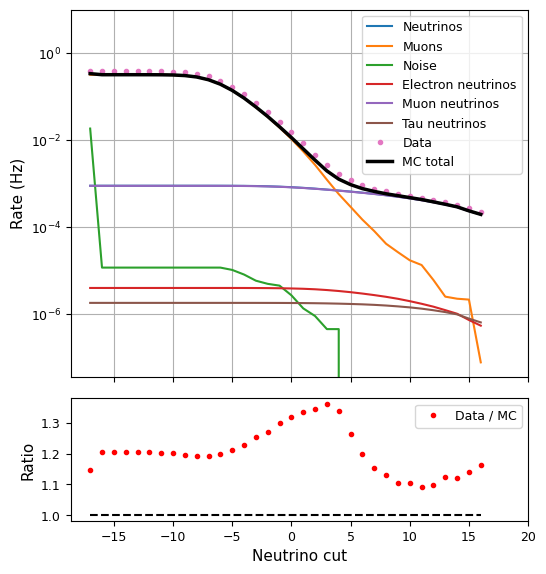

In [ ]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 0.85
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])


axs[0].plot(cuts,neutrino_rates_tracks,label='Neutrinos')
axs[0].plot(cuts,muon_rates_tracks,label='Muons')
axs[0].plot(cuts,noise_rates_tracks,label='Noise')
axs[0].plot(cuts,electron_neutrino_rates_tracks,label='Electron neutrinos')
axs[0].plot(cuts,muon_neutrino_rates_tracks,label='Muon neutrinos')
axs[0].plot(cuts,tau_neutrino_rates_tracks,label='Tau neutrinos')
axs[0].plot(cuts,RD_rates_tracks,'.',label='Data',linewidth=2.5)#,linestyle='dashed')
axs[0].plot(cuts,np.array(neutrino_rates_tracks)+np.array(muon_rates_tracks)+np.array(noise_rates_tracks),label='MC total',color='k',linewidth=2.5)
axs[0].set_ylabel('Rate (Hz)')
axs[1].set_xlabel('Neutrino cut')
axs[0].set_yscale('log')
axs[0].set_xlim(right=20)
axs[0].set_ylim(top=10)
axs[0].legend(ncol=1)
axs[0].grid(True)

RD_MC_ratio = RD_rates_tracks/(np.array(neutrino_rates_tracks)+np.array(muon_rates_tracks)+np.array(noise_rates_tracks))
axs[1].set_ylabel('Ratio')
axs[1].plot(cuts,RD_MC_ratio,'.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(cuts)-0.02,np.max(cuts)+0.02,color='k',linestyles='dashed')
axs[1].legend()
fig.tight_layout()
fig.savefig(outdir+ 'MC_vs_retro_selection_tracks_only.png', format='png', bbox_inches='tight')

In [ ]:
noise_rates_cascades = []
muon_rates_cascades = []
neutrino_rates_cascades = []
electron_neutrino_rates_cascades = []
muon_neutrino_rates_cascades = []
tau_neutrino_rates_cascades = []
RD_rates_cascades = []

cuts = np.linspace(-17,16,34)
for i in range(len(cuts)):
    neutrino_cut = cuts[i]
    
    pure_selection_MC_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12,-14,14,-16,16))) & (MC['event_no'].isin(cascade_selection_event_nos_MC))]
    pure_selection_MC_electron_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-12,12)))&(MC['event_no'].isin(cascade_selection_event_nos_MC))]
    pure_selection_MC_muon_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-14,14)))&(MC['event_no'].isin(cascade_selection_event_nos_MC))]
    pure_selection_MC_tau_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-16,16)))&(MC['event_no'].isin(cascade_selection_event_nos_MC))]
    pure_selection_MC_noise = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-1,1)))&(MC['event_no'].isin(cascade_selection_event_nos_MC))]
    pure_selection_MC_muons = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut) & (MC['pid'].isin((-13,13)))&(MC['event_no'].isin(cascade_selection_event_nos_MC))]
    pure_selection_RD = RD['event_no'][(RD['pid_neutrino_pred_logit']>neutrino_cut) & (RD['event_no'].isin(cascade_selection_event_nos_RD))]

    muon_rates_cascades.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons.to_list())]))
    noise_rates_cascades.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_noise.to_list())]))
    neutrino_rates_cascades.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos.to_list())]))
    electron_neutrino_rates_cascades.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_electron_neutrinos.to_list())]))
    muon_neutrino_rates_cascades.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muon_neutrinos.to_list())]))
    tau_neutrino_rates_cascades.append(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_tau_neutrinos.to_list())]))
    RD_rates_cascades.append(np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD.to_list())]))

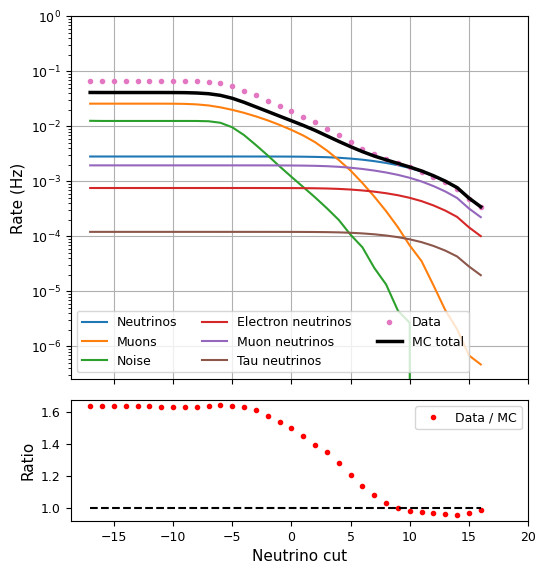

In [ ]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 0.85
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[3, 1])


axs[0].plot(cuts,neutrino_rates_cascades,label='Neutrinos')
axs[0].plot(cuts,muon_rates_cascades,label='Muons')
axs[0].plot(cuts,noise_rates_cascades,label='Noise')
axs[0].plot(cuts,electron_neutrino_rates_cascades,label='Electron neutrinos')
axs[0].plot(cuts,muon_neutrino_rates_cascades,label='Muon neutrinos')
axs[0].plot(cuts,tau_neutrino_rates_cascades,label='Tau neutrinos')
axs[0].plot(cuts,RD_rates_cascades,'.',label='Data',linewidth=2.5)#,linestyle='dashed')
axs[0].plot(cuts,np.array(neutrino_rates_cascades)+np.array(muon_rates_cascades)+np.array(noise_rates_cascades),label='MC total',color='k',linewidth=2.5)
axs[0].set_ylabel('Rate (Hz)')
axs[1].set_xlabel('Neutrino cut')
axs[0].set_yscale('log')
axs[0].set_xlim(right=20)
axs[0].set_ylim(top=1)
axs[0].legend(ncol=3)
axs[0].grid(True)

RD_MC_ratio = RD_rates_cascades/(np.array(neutrino_rates_cascades)+np.array(muon_rates_cascades)+np.array(noise_rates_cascades))
axs[1].set_ylabel('Ratio')
axs[1].plot(cuts,RD_MC_ratio,'.',color='red',label='Data / MC')
axs[1].hlines(1,np.min(cuts)-0.02,np.max(cuts)+0.02,color='k',linestyles='dashed')
axs[1].legend()
fig.tight_layout()
fig.savefig(outdir+ 'MC_vs_retro_selection_cascades_only.png', format='png', bbox_inches='tight')

In [12]:
retro = retro[(retro['event_no'].isin(MC['event_no']))&(retro['L7_oscNext_bool']==1) & (retro['L7_MuonClassifier_FullSky_ProbNu']>0.8)]

In [13]:
neutrino_cut = 12
pure_selection_MC_neutrinos = MC['event_no'][(MC['pid_neutrino_pred_logit']>neutrino_cut)]
pure_selection_RD_neutrinos = RD['event_no'][(RD['pid_neutrino_pred_logit']>neutrino_cut)]
print(len(pure_selection_MC_neutrinos))

9609948


In [14]:
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos)]))
print(np.sum(RD['total_osc_weight'][RD['event_no'].isin(pure_selection_RD_neutrinos)]))

print((MC['pid'][MC['event_no'].isin(retro['event_no'].to_list())]).value_counts())


0.0012126414530378871
0.002250582131550016
0.002235077243010643
 14.0    1789532
-14.0     818999
 16.0     798357
 12.0     768616
-12.0     347187
-16.0     301308
Name: pid, dtype: int64


In [15]:
retro_after_zenith_cut = retro['event_no'][np.cos(retro['zenith_retro'])<0.3]
retro_after_zenith_cut_2 = MC['event_no'][(np.cos(MC['zenith_pred'])<0.3) & (MC['event_no'].isin(retro['event_no'].to_list()))]
our_after_zenith_cut = MC['event_no'][(np.cos(MC['zenith_pred'])<0.3) & (MC['event_no'].isin(pure_selection_MC_neutrinos))]
our_after_zenith_cut_RD = RD['event_no'][(np.cos(RD['zenith_pred'])<0.3) & (RD['event_no'].isin(pure_selection_RD_neutrinos))]


In [16]:
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_cut)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_cut_2)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(our_after_zenith_cut)]))
print(np.sum(RD['total_osc_weight'][RD['event_no'].isin(our_after_zenith_cut_RD)]))

(MC['pid'][MC['event_no'].isin(our_after_zenith_cut)]).value_counts()
(MC['pid'][MC['event_no'].isin(retro_after_zenith_cut)]).value_counts()
(MC['pid'][MC['event_no'].isin(retro_after_zenith_cut_2)]).value_counts()

0.00089147377712873
0.000953594492579621
0.0019324578402497206
0.001895717291455617


 14.0    1424825
-14.0     653715
 16.0     632861
 12.0     614677
-12.0     277323
-16.0     238158
Name: pid, dtype: int64

In [17]:
retro_after_zenith_and_energy_cut = retro['event_no'][(retro['energy_retro'] < 300) & (retro['energy_retro'] > 5) & (retro['event_no'].isin(retro_after_zenith_cut))]
retro_after_zenith_and_energy_cut_2 = MC['event_no'][(MC['energy_pred'] < 300) & (MC['energy_pred'] > 5) & (MC['event_no'].isin(retro_after_zenith_cut_2))]
our_after_zenith_and_energy_cut = MC['event_no'][(MC['energy_pred'] < 300) & (MC['energy_pred'] > 5) & (MC['event_no'].isin(our_after_zenith_cut))]
our_after_zenith_and_energy_cut_RD = RD['event_no'][(RD['energy_pred'] < 300) & (RD['energy_pred'] > 5) & (RD['event_no'].isin(our_after_zenith_cut_RD))]

In [18]:
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_and_energy_cut)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_and_energy_cut_2)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(our_after_zenith_and_energy_cut)]))
print(np.sum(RD['total_osc_weight'][RD['event_no'].isin(our_after_zenith_and_energy_cut_RD)]))
print((MC['pid'][MC['event_no'].isin(our_after_zenith_and_energy_cut)]).value_counts())

0.0008174833943349918
0.0009159926787122145
0.0017376355332795715
0.0016556884318154929
 14.0    2643723
 16.0    1251064
-14.0    1193857
 12.0    1116847
-12.0     498258
-16.0     473270
 13.0        186
Name: pid, dtype: int64


In [19]:
retro_after_zenith_and_energy_cut = retro['event_no'][(retro['energy_retro'] < 300) & (retro['energy_retro'] > 5) & (retro['event_no'].isin(retro_after_zenith_cut))]
retro_after_zenith_and_energy_cut_2 = MC['event_no'][(MC['energy_pred'] < 300) & (MC['energy_pred'] > 5) & (MC['event_no'].isin(retro_after_zenith_cut_2))]
our_after_zenith_and_energy_cut = MC['event_no'][(MC['energy_pred'] < 300) & (MC['energy_pred'] > 5) & (MC['event_no'].isin(our_after_zenith_cut))]
our_after_zenith_and_energy_cut_RD = RD['event_no'][(RD['energy_pred'] < 300) & (RD['energy_pred'] > 5) & (RD['event_no'].isin(our_after_zenith_cut_RD))]

In [20]:
def calc_rho_36(x,y) :
    '''
    Radial distance from string 36 (approximately central within DeepCore)
    '''
    return np.sqrt( (x-46.29) ** 2 + (y+34.88) ** 2 )

In [21]:
MC['rho'] = calc_rho_36(MC['position_x_pred'].values,MC['position_y_pred'].values)
RD['rho'] = calc_rho_36(RD['position_x_pred'].values,RD['position_y_pred'].values)
retro['rho'] = calc_rho_36(retro['position_x_retro'].values,retro['position_y_retro'].values)

In [22]:
retro_after_zenith_and_energy_and_containment_cut = retro['event_no'][(retro['rho'] < 300) & (retro['position_z_retro'] > -500) & (retro['position_z_retro'] < -200) & (retro['event_no'].isin(retro_after_zenith_and_energy_cut))]
retro_after_zenith_and_energy_and_containment_cut_2 = MC['event_no'][(MC['rho'] < 300) & (MC['position_z_pred'] > -500) & (MC['position_z_pred'] < -200) & (MC['event_no'].isin(retro_after_zenith_and_energy_cut_2))]
our_after_zenith_and_energy_and_containment_cut = MC['event_no'][(MC['rho'] < 300) & (MC['position_z_pred'] > -500) & (MC['position_z_pred'] < -200) & (MC['event_no'].isin(our_after_zenith_and_energy_cut))]
our_after_zenith_and_energy_and_containment_cut_RD = RD['event_no'][(RD['rho'] < 300) & (RD['position_z_pred'] > -500) & (RD['position_z_pred'] < -200) & (RD['event_no'].isin(our_after_zenith_and_energy_cut_RD))]

In [23]:
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut_2)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut)]))
print(np.sum(RD['total_osc_weight'][RD['event_no'].isin(our_after_zenith_and_energy_and_containment_cut_RD)]))
print((MC['pid'][MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut)]).value_counts())
retro_final_1 = np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut)])
retro_final_2 = np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut_2)])
our_final = np.sum(MC['total_osc_weight'][MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut)])
our_final_RD = np.sum(RD['total_osc_weight'][RD['event_no'].isin(our_after_zenith_and_energy_and_containment_cut_RD)])

0.0007936852227851161
0.0008867743153841535
0.00138219322622784
0.0012887506963869205
 14.0    2049944
 16.0     993049
-14.0     918540
 12.0     907234
-12.0     405819
-16.0     375010
 13.0        155
Name: pid, dtype: int64


In [24]:
our_final_neutrinos = np.sum(MC['total_osc_weight'][(MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut))&(MC['pid'].isin((-12,12,-14,14,-16,16)))])
our_final_muons = np.sum(MC['total_osc_weight'][(MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut))&(MC['pid'].isin((-13,13)))])
our_final_noise = np.sum(MC['total_osc_weight'][(MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut))&(MC['pid'].isin((-1,1)))])

retro_final_neutrinos_1 = np.sum(MC['total_osc_weight'][(MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut))&(MC['pid'].isin((-12,12,-14,14,-16,16)))])

retro_final_neutrinos_2 = np.sum(MC['total_osc_weight'][(MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut_2))&(MC['pid'].isin((-12,12,-14,14,-16,16)))])


In [25]:
print('our final rate',our_final)
print('our final neutrino rate',our_final_neutrinos)
print('our final muon rate',our_final_muons)
print('our final noise rate',our_final_noise)
print('our percent neutrinos',our_final_neutrinos/our_final*100)
print('our percent muons',our_final_muons/our_final*100)
print('our percent noise',our_final_noise/our_final*100)
print('our final rate RD:',our_final_RD)
print('RD to MC ratio = ',our_final_RD/our_final)

our final rate 0.00138219322622784
our final neutrino rate 0.0013725027028395449
our final muon rate 9.6905233882938e-06
our final noise rate 0.0
our percent neutrinos 99.29890241071854
our percent muons 0.7010975892813717
our percent noise 0.0
our final rate RD: 0.0012887506963869205
RD to MC ratio =  0.93239546536056


In [26]:

print('retro_1 final neutrino rate',retro_final_neutrinos_1)

retro_1 final neutrino rate 0.0007936852227851161


In [27]:
print('retro_2 final neutrino rate',retro_final_neutrinos_2)


retro_2 final neutrino rate 0.0008867743153841535


In [28]:
print(our_final/retro_final_1*100-100)
print(our_final/retro_final_2*100-100)

74.14879180660486
55.867530469583954


In [29]:
retro_after_zenith_and_energy_cut_extended = retro['event_no'][(retro['energy_retro'] < 10**(1.75)) & (retro['energy_retro'] > 5) & (retro['event_no'].isin(retro_after_zenith_cut))]
retro_after_zenith_and_energy_cut_2_extended = MC['event_no'][(MC['energy_pred'] < 10**(1.75)) & (MC['energy_pred'] > 5) & (MC['event_no'].isin(retro_after_zenith_cut_2))]
our_after_zenith_and_energy_cut_extended = MC['event_no'][(MC['energy_pred'] < 10**(1.75)) & (MC['energy_pred'] > 5) & (MC['event_no'].isin(our_after_zenith_cut))]
our_after_zenith_and_energy_cut_RD_extended = RD['event_no'][(RD['energy_pred'] < 10**(1.75)) & (RD['energy_pred'] > 5) & (RD['event_no'].isin(our_after_zenith_cut_RD))]

retro_after_zenith_and_energy_and_containment_cut_extended = retro['event_no'][(retro['rho'] < 300) & (retro['position_z_retro'] > -500) & (retro['position_z_retro'] < -200) & (retro['event_no'].isin(retro_after_zenith_and_energy_cut_extended))]
retro_after_zenith_and_energy_and_containment_cut_2_extended = MC['event_no'][(MC['rho'] < 300) & (MC['position_z_pred'] > -500) & (MC['position_z_pred'] < -200) & (MC['event_no'].isin(retro_after_zenith_and_energy_cut_2_extended))]
our_after_zenith_and_energy_and_containment_cut_extended = MC['event_no'][(MC['rho'] < 300) & (MC['position_z_pred'] > -500) & (MC['position_z_pred'] < -200) & (MC['event_no'].isin(our_after_zenith_and_energy_cut_extended))]
our_after_zenith_and_energy_and_containment_cut_RD_extended = RD['event_no'][(RD['rho'] < 300) & (RD['position_z_pred'] > -500) & (RD['position_z_pred'] < -200) & (RD['event_no'].isin(our_after_zenith_and_energy_cut_RD_extended))]

In [30]:
neutrino_cut = 12
pure_selection_MC_neutrinos_for_plot = MC['event_no'][((MC['pid_neutrino_pred_logit']>neutrino_cut)) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]

In [31]:
same = pd.merge(pure_selection_MC_neutrinos_for_plot,retro,on='event_no',how='inner')
only_retro_event_nos = retro['event_no'][~retro['event_no'].isin(same['event_no'])]
only_our_selection_event_nos = MC['event_no'][(~MC['event_no'].isin(same['event_no']))&(MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list()))]

In [32]:
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'])]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())]))

0.0012126414530378871
0.002224562395705728
0.0003292647099830056
0.0013411856526508485
0.0008833767430548811


[-17.  -16.5 -16.  -15.5 -15.  -14.5 -14.  -13.5 -13.  -12.5]


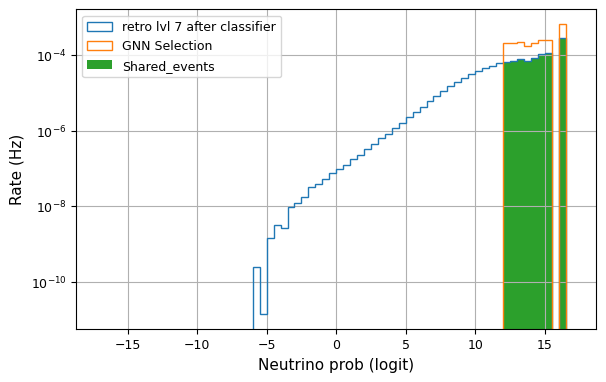

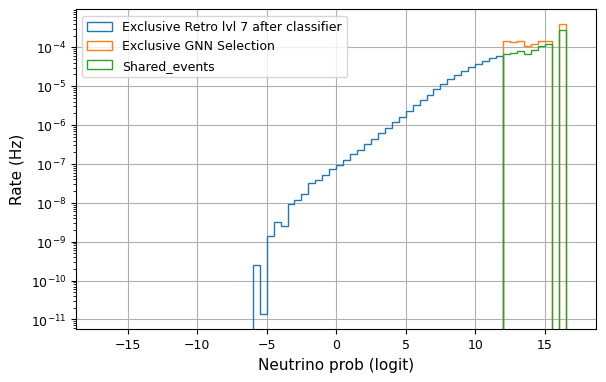

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-17,17,69)
plt.hist(MC['pid_neutrino_pred_logit'][MC['event_no'].isin(retro['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(MC['pid_neutrino_pred_logit'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(MC['pid_neutrino_pred_logit'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared_events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Neutrino prob (logit)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_neutrino_prob_logit.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-17,17,69)
print(bins[:10])
plt.hist(MC['pid_neutrino_pred_logit'][MC['event_no'].isin(only_retro_event_nos.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Exclusive Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(MC['pid_neutrino_pred_logit'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='Exclusive GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(MC['pid_neutrino_pred_logit'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared_events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Neutrino prob (logit)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_neutrino_prob_logit_exclusive.png', format='png', bbox_inches='tight')

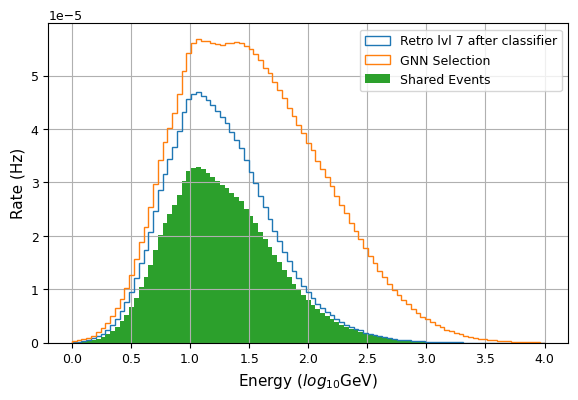

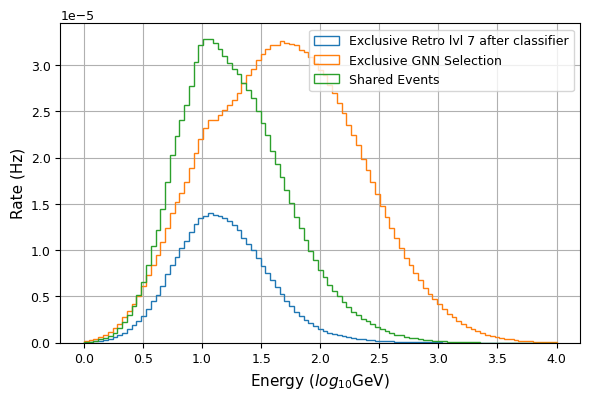

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(0,4,100)
plt.hist(np.log10(MC['energy'][MC['event_no'].isin(retro['event_no'].to_list())]),weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.log10(MC['energy'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())]),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.log10(MC['energy'][MC['event_no'].isin(same['event_no'].to_list())]),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel(r'Energy ($log_{10}$GeV)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_energy.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(0,4,100)
plt.hist(np.log10(MC['energy'][MC['event_no'].isin(only_retro_event_nos)]),weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Exclusive Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.log10(MC['energy'][MC['event_no'].isin(only_our_selection_event_nos.to_list())]),weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='Exclusive GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.log10(MC['energy'][MC['event_no'].isin(same['event_no'].to_list())]),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel(r'Energy ($log_{10}$GeV)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)

fig.savefig(outdir+ 'MC_vs_retro_selection_energy_exclusive.png', format='png', bbox_inches='tight')

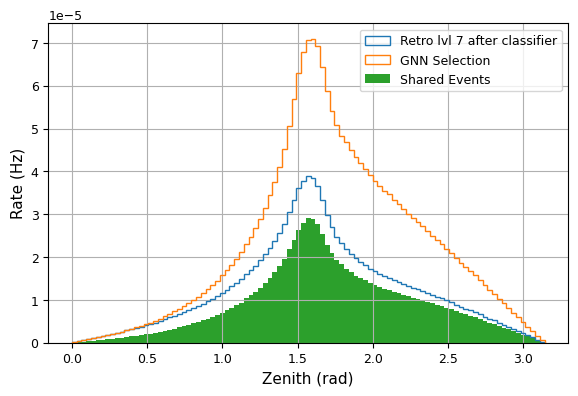

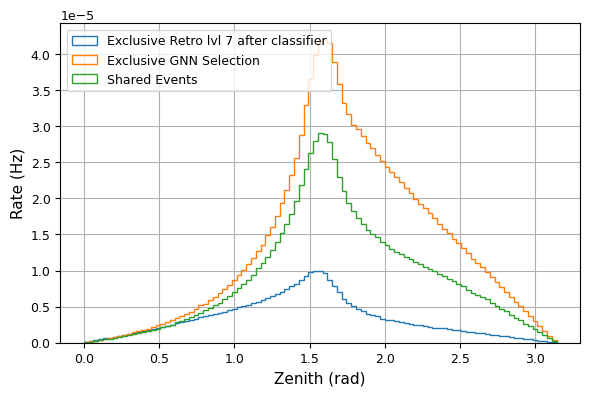

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(0,np.pi,100)
plt.hist(MC['zenith'][MC['event_no'].isin(retro['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(MC['zenith'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(MC['zenith'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Zenith (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_zenith.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(0,np.pi,100)
plt.hist(MC['zenith'][MC['event_no'].isin(only_retro_event_nos.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Exclusive Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(MC['zenith'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='Exclusive GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(MC['zenith'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Zenith (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_zenith_exclusive.png', format='png', bbox_inches='tight')

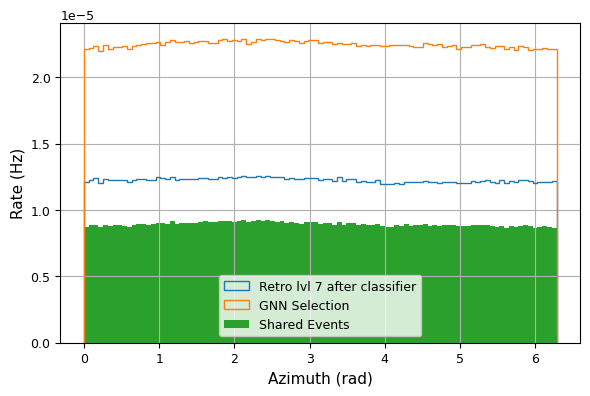

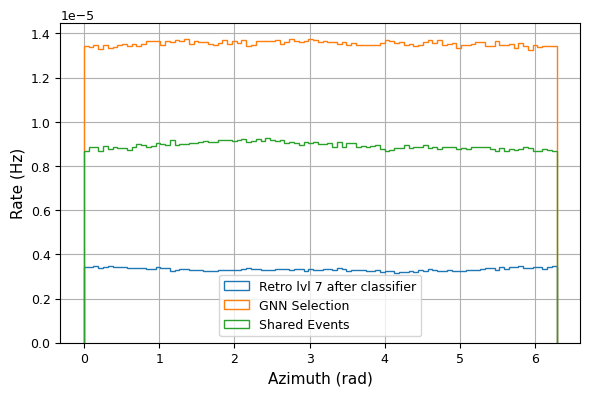

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(0,2*np.pi,100)
plt.hist(MC['azimuth'][MC['event_no'].isin(retro['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(MC['azimuth'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(MC['azimuth'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Azimuth (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_azimuth.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(0,2*np.pi,100)
plt.hist(MC['azimuth'][MC['event_no'].isin(only_retro_event_nos.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(MC['azimuth'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(MC['azimuth'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Azimuth (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_azimuth_exclusive.png', format='png', bbox_inches='tight')


#outdir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/plotting/MC_results_vs_retro/"
#fig.savefig(outdir+ 'MC_vs_retro_selection_all_long.png', format='png', bbox_inches='tight')

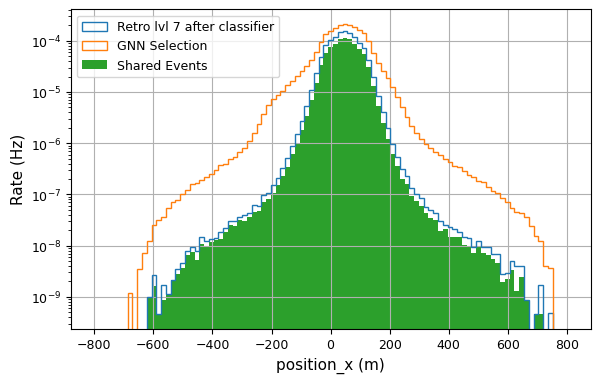

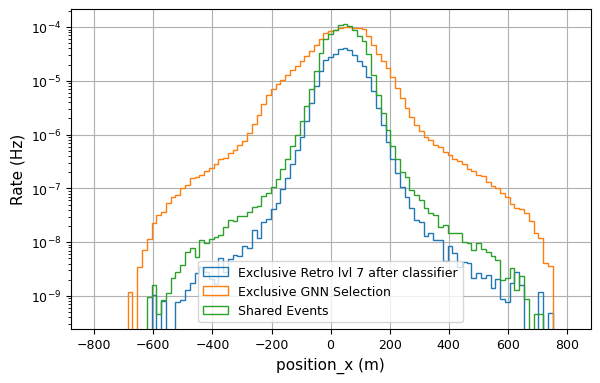

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-800,800,100)
plt.hist(np.clip(MC['position_x'][MC['event_no'].isin(retro['event_no'].to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_x'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_x'][MC['event_no'].isin(same['event_no'].to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('position_x (m)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_posx.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-800,800,100)
plt.hist(np.clip(MC['position_x'][MC['event_no'].isin(only_retro_event_nos.to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Exclusive Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_x'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='Exclusive GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_x'][MC['event_no'].isin(same['event_no'].to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('position_x (m)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_posx_exclusive.png', format='png', bbox_inches='tight')

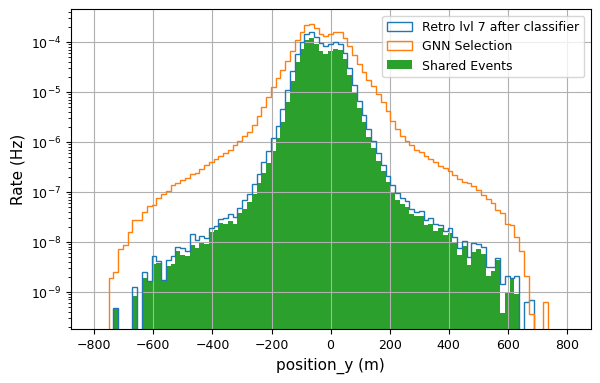

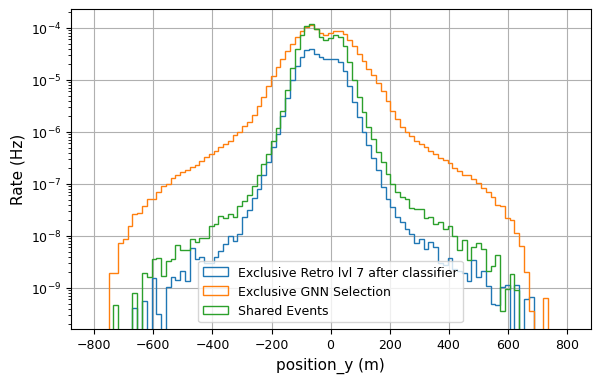

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-800,800,100)
plt.hist(np.clip(MC['position_y'][MC['event_no'].isin(retro['event_no'].to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_y'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_y'][MC['event_no'].isin(same['event_no'].to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('position_y (m)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_posy.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-800,800,100)
plt.hist(np.clip(MC['position_y'][MC['event_no'].isin(only_retro_event_nos.to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Exclusive Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_y'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='Exclusive GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_y'][MC['event_no'].isin(same['event_no'].to_list())],-750,750),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('position_y (m)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_posy_exclusive.png', format='png', bbox_inches='tight')

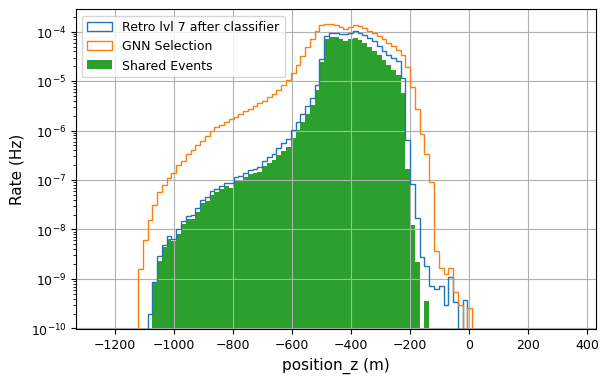

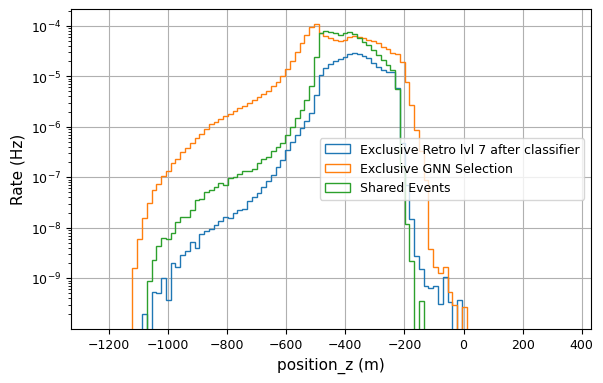

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-1250,350,100)
plt.hist(np.clip(MC['position_z'][MC['event_no'].isin(retro['event_no'].to_list())],-1200,300),weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_z'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],-1200,300),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_z'][MC['event_no'].isin(same['event_no'].to_list())],-1200,300),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('position_z (m)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_posz.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-1250,350,100)
plt.hist(np.clip(MC['position_z'][MC['event_no'].isin(only_retro_event_nos.to_list())],-1200,300),weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Exclusive Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_z'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],-1200,300),weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='Exclusive GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['position_z'][MC['event_no'].isin(same['event_no'].to_list())],-1200,300),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('position_z (m)')
axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_posz_exclusive.png', format='png', bbox_inches='tight')

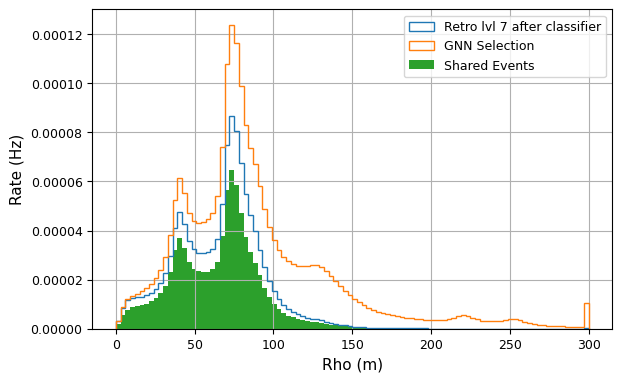

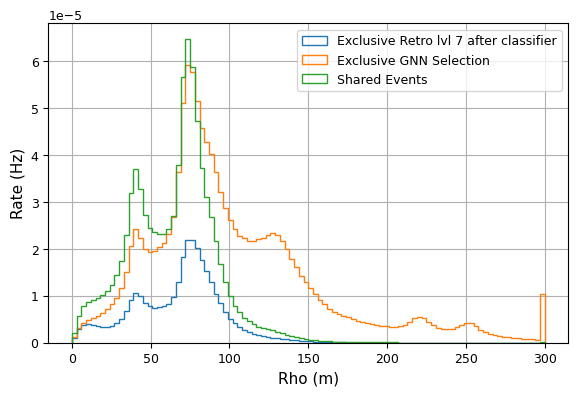

In [ ]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-0,300,101)
plt.hist(np.clip(MC['rho'][MC['event_no'].isin(retro['event_no'].to_list())],0,300),weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['rho'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],0,300),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['rho'][MC['event_no'].isin(same['event_no'].to_list())],0,300),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Rho (m)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=101)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_rho.png', format='png', bbox_inches='tight')

fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-0,300,101)
plt.hist(np.clip(MC['rho'][MC['event_no'].isin(only_retro_event_nos.to_list())],0,300),weights=MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos.to_list())],label='Exclusive Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['rho'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],0,300),weights=MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos.to_list())],label='Exclusive GNN Selection',bins=bins,alpha=1,histtype='step')
plt.hist(np.clip(MC['rho'][MC['event_no'].isin(same['event_no'].to_list())],0,300),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='step')

axs.set_ylabel('Rate (Hz)')
axs.set_xlabel('Rho (m)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=101)
axs.legend()
axs.grid(True)
fig.savefig(outdir+ 'MC_vs_retro_selection_rho_exclusive.png', format='png', bbox_inches='tight')

In [33]:
#Residual plots

In [34]:
MC['energy_residual'] = np.log10(MC['energy_pred']) - np.log10(MC['energy'])
MC['zenith_residual'] = MC['zenith_pred'] - MC['zenith']
MC['azimuth_residual'] = MC['azimuth_pred'] - MC['azimuth']

/groups/icecube/peter/anaconda3/envs/graphnet/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
MC['azimuth_residual'][MC['azimuth_residual'] > np.pi] = MC['azimuth_residual'][MC['azimuth_residual'] > np.pi] - np.pi
MC['azimuth_residual'][MC['azimuth_residual'] < -np.pi] = MC['azimuth_residual'][MC['azimuth_residual'] < -np.pi] + np.pi

/tmp/ipykernel_45056/1086083323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MC['azimuth_residual'][MC['azimuth_residual'] > np.pi] = MC['azimuth_residual'][MC['azimuth_residual'] > np.pi] - np.pi
/tmp/ipykernel_45056/1086083323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MC['azimuth_residual'][MC['azimuth_residual'] > np.pi] = MC['azimuth_residual'][MC['azimuth_residual'] > np.pi] - np.pi
/tmp/ipykernel_45056/1086083323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

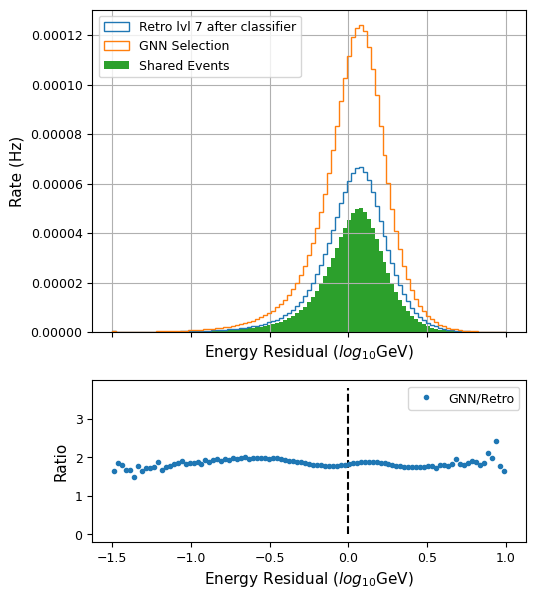

In [36]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

bins=np.linspace(-1.5,1,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_energy,_,_ = axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(retro['event_no'].to_list())],-1.5,1),weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
our_counts_energy,_,_ = axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],-1.5,1),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(same['event_no'].to_list())],-1.5,1),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel(r'Energy Residual ($log_{10}$GeV)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs[0].legend()
axs[0].grid(True)

axs[1].vlines(0,0,3.8,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_energy/retro_counts_energy,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel(r'Energy Residual ($log_{10}$GeV)')
axs[1].set_ylabel('Ratio')



fig.savefig(outdir+ 'MC_vs_retro_selection_energy_residual.png', format='png', bbox_inches='tight')


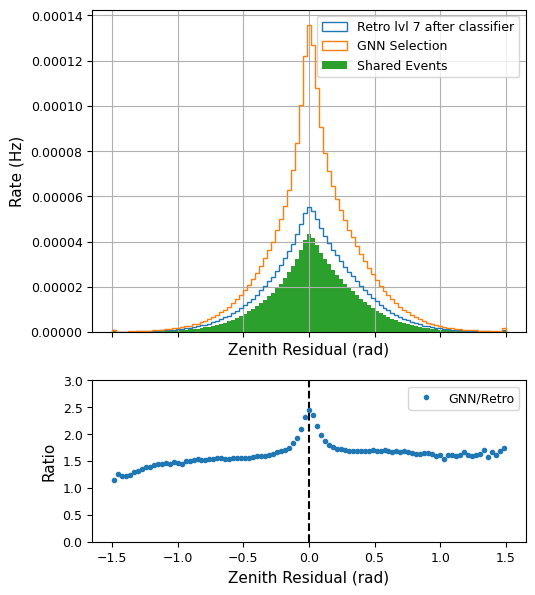

In [37]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

bins=np.linspace(-1.5,1.5,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_zenith,_,_ = axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(retro['event_no'].to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
our_counts_zenith,_,_ = axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(same['event_no'].to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel('Zenith Residual (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs[0].legend()
axs[0].grid(True)

axs[1].vlines(0,0,3,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_zenith/retro_counts_zenith,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel('Zenith Residual (rad)')
axs[1].set_ylabel('Ratio')
axs[1].set_ylim(0,3)

fig.savefig(outdir+ 'MC_vs_retro_selection_zenith_residual.png', format='png', bbox_inches='tight')


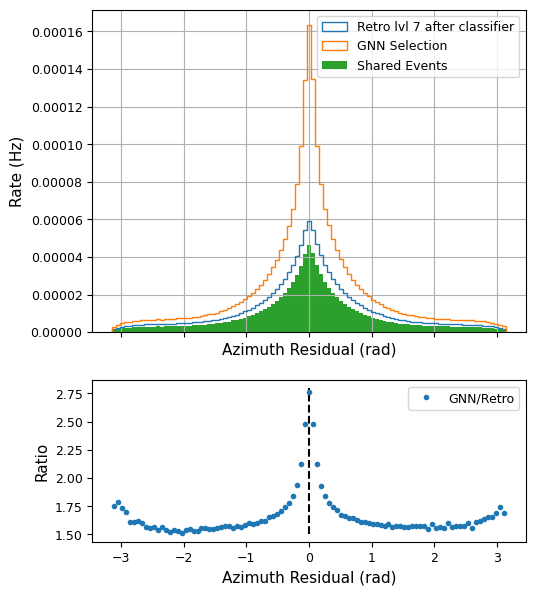

In [38]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

#fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-np.pi,np.pi,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_azimuth, _, _ = axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(retro['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(retro['event_no'].to_list())],label='Retro lvl 7 after classifier',bins=bins,alpha=1,histtype='step')
our_counts_azimuth, _, _ = axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection',bins=bins,alpha=1,histtype='step')
axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel('Azimuth Residual (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs[0].legend()
axs[0].grid(True)

axs[1].vlines(0,1.5,2.8,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_azimuth/retro_counts_azimuth,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel('Azimuth Residual (rad)')
axs[1].set_ylabel('Ratio')

fig.savefig(outdir+ 'MC_vs_retro_selection_azimuth_residual.png', format='png', bbox_inches='tight')


In [39]:
our_after_zenith_and_energy_and_containment_cut

199955      68837578.0
216240      68862314.0
301525      68967538.0
553994      69491361.0
755309      69848647.0
               ...    
36744136    38884961.0
36744149    38884975.0
36744162    38884988.0
36744168    38884994.0
36744793    38885629.0
Name: event_no, Length: 5649751, dtype: float64

In [40]:
neutrino_cut = 12
pure_selection_MC_neutrinos_for_plot = MC['event_no'][(MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut)) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]
pure_selection_MC_neutrinos_retro = MC['event_no'][(MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut)) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]

In [41]:
same = pd.merge(pure_selection_MC_neutrinos_for_plot,pure_selection_MC_neutrinos_retro,on='event_no',how='inner')
only_retro_event_nos = retro['event_no'][(~retro['event_no'].isin(same['event_no'])) & (retro['event_no'].isin(pure_selection_MC_neutrinos_retro))]
only_our_selection_event_nos = MC['event_no'][(~MC['event_no'].isin(same['event_no']))&(MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list()))]

In [42]:
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(only_retro_event_nos)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(only_our_selection_event_nos)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())]))

0.0007936852227851161
0.0013725027028395449
0.0002157327091675844
0.0007945501892220137
0.000577952513617532


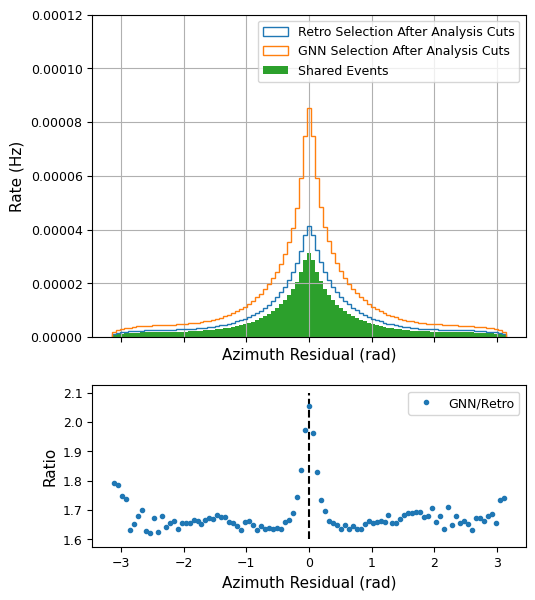

In [43]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

#fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-np.pi,np.pi,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_azimuth, _, _ = axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro.to_list())],label='Retro Selection After Analysis Cuts',bins=bins,alpha=1,histtype='step')
our_counts_azimuth, _, _ = axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection After Analysis Cuts',bins=bins,alpha=1,histtype='step')
axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(same['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel('Azimuth Residual (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
axs[0].set_ylim(top=12*10**(-5))
axs[0].legend()
axs[0].grid(True)

axs[1].vlines(0,1.6,2.1,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_azimuth/retro_counts_azimuth,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel('Azimuth Residual (rad)')
axs[1].set_ylabel('Ratio')

fig.savefig(outdir+ 'MC_vs_retro_selection_azimuth_residual_after_analysis_cuts.png', format='png', bbox_inches='tight')


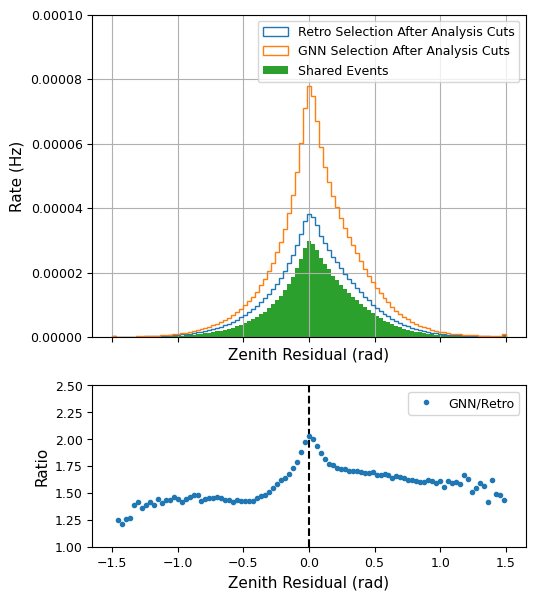

In [44]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

#fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-1.5,1.5,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_zenith, _, _ = axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro.to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro.to_list())],label='Retro Selection After Analysis Cuts',bins=bins,alpha=1,histtype='step')
our_counts_zenith, _, _ = axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection After Analysis Cuts',bins=bins,alpha=1,histtype='step')
axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(same['event_no'].to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel('Zenith Residual (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs[0].set_ylim(top=10*10**(-5))
axs[0].legend()
axs[0].grid(True)

axs[1].vlines(0,1,2.5,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_zenith/retro_counts_zenith,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel('Zenith Residual (rad)')
axs[1].set_ylabel('Ratio')
axs[1].set_ylim(1,2.5)


fig.savefig(outdir+ 'MC_vs_retro_selection_zenith_residual_after_analysis_cuts.png', format='png', bbox_inches='tight')


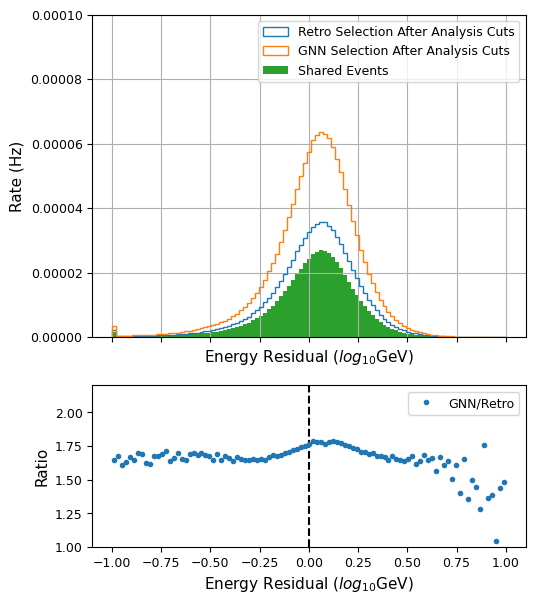

In [45]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

bins=np.linspace(-1,1,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_energy,_,_ = axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro.to_list())],-1,1),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro.to_list())],label='Retro Selection After Analysis Cuts',bins=bins,alpha=1,histtype='step')
our_counts_energy,_,_ = axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],-1,1),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot.to_list())],label='GNN Selection After Analysis Cuts',bins=bins,alpha=1,histtype='step')
axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(same['event_no'].to_list())],-1,1),weights=MC['total_osc_weight'][MC['event_no'].isin(same['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel(r'Energy Residual ($log_{10}$GeV)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs[0].set_ylim(top=10*10**(-5))
axs[0].legend()
axs[0].grid(True)
axs[1].vlines(0,1,2.2,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_energy/retro_counts_energy,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel(r'Energy Residual ($log_{10}$GeV)')
axs[1].set_ylabel('Ratio')
axs[1].set_ylim(1,2.2)




fig.savefig(outdir+ 'MC_vs_retro_selection_energy_residual_after_analysis_cuts.png', format='png', bbox_inches='tight')


In [70]:
neutrino_cut = 12
pure_selection_MC_total_for_plot_extended = MC['event_no'][(MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut_extended)) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]
pure_selection_MC_neutrinos_for_plot_extended = MC['event_no'][(MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut_extended)) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]
pure_selection_MC_muons_for_plot_extended = MC['event_no'][(MC['event_no'].isin(our_after_zenith_and_energy_and_containment_cut_extended)) & (MC['pid'].isin((-13,13)))]
pure_selection_MC_neutrinos_retro_extended = MC['event_no'][(MC['event_no'].isin(retro_after_zenith_and_energy_and_containment_cut_extended)) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]

same_extended = pd.merge(pure_selection_MC_neutrinos_for_plot_extended,pure_selection_MC_neutrinos_retro_extended,on='event_no',how='inner')
only_retro_event_nos_extended = retro['event_no'][(~retro['event_no'].isin(same_extended['event_no'])) & (retro['event_no'].isin(pure_selection_MC_neutrinos_retro_extended))]
only_our_selection_event_nos_extended = MC['event_no'][(~MC['event_no'].isin(same_extended['event_no']))&(MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended.to_list()))]

In [71]:
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_total_for_plot_extended)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_muons_for_plot_extended)]))
print(np.sum(MC['total_osc_weight'][MC['event_no'].isin(same_extended['event_no'].to_list())]))

0.0006965428172894582
0.0010358117350816275
0.0010298048999870105
6.0068350946179625e-06
0.00048703536725290997


In [56]:
np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended)])/np.sum(MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended)])

1.4784516822589824

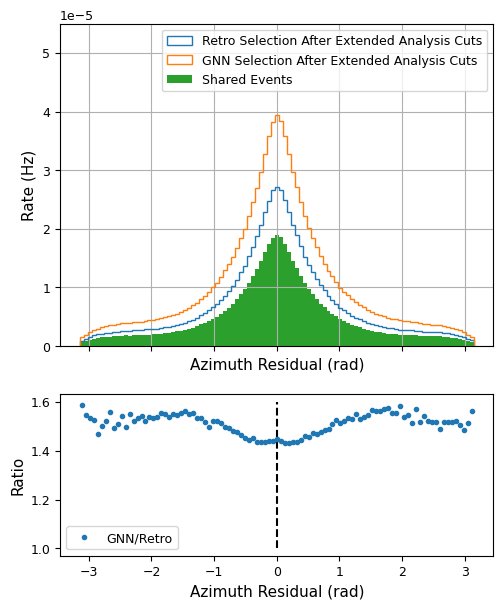

In [54]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

#fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-np.pi,np.pi,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_azimuth, _, _ = axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended.to_list())],label='Retro Selection After Extended Analysis Cuts',bins=bins,alpha=1,histtype='step')
our_counts_azimuth, _, _ = axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended.to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended.to_list())],label='GNN Selection After Extended Analysis Cuts',bins=bins,alpha=1,histtype='step')
axs[0].hist(MC['azimuth_residual'][MC['event_no'].isin(same_extended['event_no'].to_list())],weights=MC['total_osc_weight'][MC['event_no'].isin(same_extended['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel('Azimuth Residual (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
axs[0].set_ylim(top=5.5*10**(-5))
axs[0].legend()
axs[0].grid(True)

axs[1].vlines(0,1,1.6,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_azimuth/retro_counts_azimuth,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel('Azimuth Residual (rad)')
axs[1].set_ylabel('Ratio')

fig.savefig(outdir+ 'MC_vs_retro_selection_azimuth_residual_after_analysis_cuts_extended.png', format='png', bbox_inches='tight')


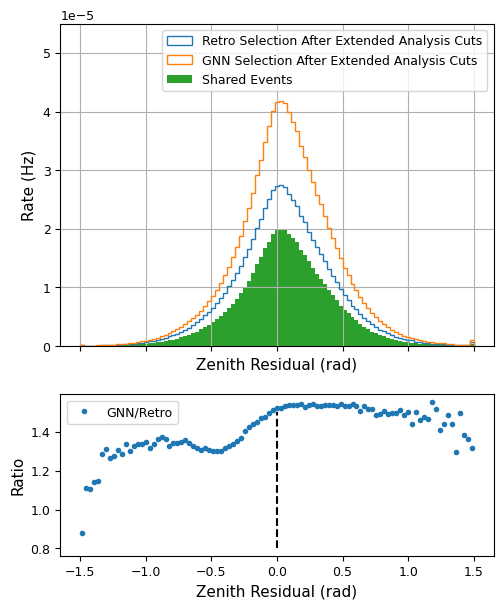

In [53]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

#fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1.2))
bins=np.linspace(-1.5,1.5,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_zenith, _, _ = axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended.to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended.to_list())],label='Retro Selection After Extended Analysis Cuts',bins=bins,alpha=1,histtype='step')
our_counts_zenith, _, _ = axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended.to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended.to_list())],label='GNN Selection After Extended Analysis Cuts',bins=bins,alpha=1,histtype='step')
axs[0].hist(np.clip(MC['zenith_residual'][MC['event_no'].isin(same_extended['event_no'].to_list())],-1.5,1.5),weights=MC['total_osc_weight'][MC['event_no'].isin(same_extended['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel('Zenith Residual (rad)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
axs[0].set_ylim(top=5.5*10**(-5))
axs[0].legend()
axs[0].grid(True)

axs[1].vlines(0,0.8,1.5,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_zenith/retro_counts_zenith,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel('Zenith Residual (rad)')
axs[1].set_ylabel('Ratio')

fig.savefig(outdir+ 'MC_vs_retro_selection_zenith_residual_after_analysis_cuts_extended.png', format='png', bbox_inches='tight')

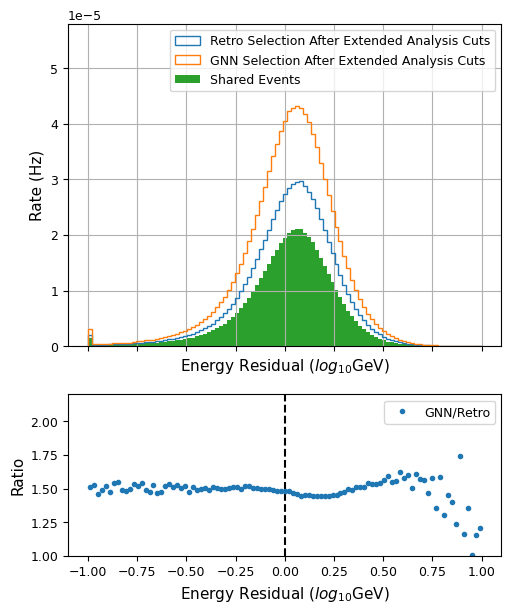

In [52]:
figure_size = set_size('thesis',subplots = (2,1))
figure_size_yfrac = 1
fig, axs = plt.subplots(2,1,figsize=(figure_size[0],figure_size[1]*figure_size_yfrac),sharex=True,height_ratios=[2, 1])

bins=np.linspace(-1,1,100)
bins_middle = (bins[1:]+bins[:-1])/2
retro_counts_energy,_,_ = axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended.to_list())],-1,1),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_retro_extended.to_list())],label='Retro Selection After Extended Analysis Cuts',bins=bins,alpha=1,histtype='step')
our_counts_energy,_,_ = axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended.to_list())],-1,1),weights=MC['total_osc_weight'][MC['event_no'].isin(pure_selection_MC_neutrinos_for_plot_extended.to_list())],label='GNN Selection After Extended Analysis Cuts',bins=bins,alpha=1,histtype='step')
axs[0].hist(np.clip(MC['energy_residual'][MC['event_no'].isin(same_extended['event_no'].to_list())],-1,1),weights=MC['total_osc_weight'][MC['event_no'].isin(same_extended['event_no'].to_list())],label='Shared Events',bins=bins,alpha=1,histtype='stepfilled')

axs[0].set_ylabel('Rate (Hz)')
axs[0].set_xlabel(r'Energy Residual ($log_{10}$GeV)')
#axs.set_yscale('log')
#axs.set_xlim(right=20)
#axs.set_ylim(top=100)
axs[0].set_ylim(top=5.8*10**(-5))
axs[0].legend()
axs[0].grid(True)
axs[1].vlines(0,1,2.2,linestyle='--',color='k')
axs[1].plot(bins_middle,our_counts_energy/retro_counts_energy,'.',label='GNN/Retro')
axs[1].legend()
axs[1].set_xlabel(r'Energy Residual ($log_{10}$GeV)')
axs[1].set_ylabel('Ratio')
axs[1].set_ylim(1,2.2)




fig.savefig(outdir+ 'MC_vs_retro_selection_energy_residual_after_analysis_cuts_extended.png', format='png', bbox_inches='tight')

In [57]:
print(sum(MC['total_osc_weight']))

0.4665492703461861


In [68]:
print('total rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('neutrino rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]))
print('muon rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-13,13)))]))
print('noise rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-1,1)))]))
print('total rate RD = ',sum(RD['total_osc_weight'][(RD['pid_neutrino_pred_logit']>12)]))

print('percent neutrinos MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-12,12,-14,14,-16,16)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('percent muons MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-13,13)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('percent noise MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-1,1)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))

print('RD/MC ratio = ',sum(RD['total_osc_weight'][(RD['pid_neutrino_pred_logit']>12)])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>12) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))


total rate MC =  0.0022505821315498974
neutrino rate MC =  0.0022245623957056026
muon rate MC =  2.6019735844285443e-05
noise rate MC =  0
total rate RD =  0.0022350772430108643
percent neutrinos MC =  0.9884386641662458
percent muons MC =  0.01156133583375007
percent noise MC =  0.0
RD/MC ratio =  0.993110720856761


In [67]:
print('total rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('neutrino rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]))
print('muon rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-13,13)))]))
print('noise rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-1,1)))]))
print('total rate RD = ',sum(RD['total_osc_weight'][(RD['pid_neutrino_pred_logit']>10)]))

print('percent neutrinos MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-12,12,-14,14,-16,16)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('percent muons MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-13,13)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('percent noise MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-1,1)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))

print('RD/MC ratio = ',sum(RD['total_osc_weight'][(RD['pid_neutrino_pred_logit']>10)])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>10) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))

total rate MC =  0.003217045268866239
neutrino rate MC =  0.0030913909663682964
muon rate MC =  0.00012162752841213349
noise rate MC =  4.026774085801364e-06
total rate RD =  0.003240389605142739
percent neutrinos MC =  0.9609410835110113
percent muons MC =  0.03780721694817737
percent noise MC =  0.001251699540808915
RD/MC ratio =  1.007256452528791


In [69]:
print('total rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('neutrino rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-12,12,-14,14,-16,16)))]))
print('muon rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-13,13)))]))
print('noise rate MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-1,1)))]))
print('total rate RD = ',sum(RD['total_osc_weight'][(RD['pid_neutrino_pred_logit']>8)]))

print('percent neutrinos MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-12,12,-14,14,-16,16)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('percent muons MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-13,13)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))
print('percent noise MC = ',sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-1,1)))])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))

print('RD/MC ratio = ',sum(RD['total_osc_weight'][(RD['pid_neutrino_pred_logit']>8)])/sum(MC['total_osc_weight'][(MC['pid_neutrino_pred_logit']>8) & (MC['pid'].isin((-12,12,-14,14,-16,16,-13,13,-1,1)))]))

total rate MC =  0.004358530402837158
neutrino rate MC =  0.003854859793674481
muon rate MC =  0.00047995738399048214
noise rate MC =  2.3713225171941366e-05
total rate RD =  0.004607277355837999
percent neutrinos MC =  0.8844402671058998
percent muons MC =  0.11011908593732807
percent noise MC =  0.005440646956713986
RD/MC ratio =  1.0570712900933124
